In [1]:
import pandas as pd
import sys
sys.path.append('/home/nick.ponvert/src/nick-allen/projects/ophys_glm')

import os
import json
from matplotlib import pyplot as plt
from tqdm import tqdm
import scipy
import model_utils as m
import numpy as np

from allensdk.brain_observatory.behavior.behavior_project_cache import BehaviorProjectCache
from visual_behavior.translator.allensdk_sessions import sdk_utils
from visual_behavior.translator.allensdk_sessions import session_attributes
from visual_behavior.ophys.response_analysis import response_processing as rp

#  from allensdk.brain_observatory.behavior import behavior_project_cache as bpc
#  from allensdk.brain_observatory.behavior import response_processing as rp

import argparse

manifest_default = '/allen/programs/braintv/workgroups/nc-ophys/nick.ponvert/data/behavior_project_cache_20200127/manifest.json'


In [2]:
osid = 877946125

cache = BehaviorProjectCache.from_lims(manifest=manifest_default)
oeid = sdk_utils.get_oeid_from_osid(osid, cache)

session = cache.get_session_data(oeid)

In [3]:
# Add stim response / extended stim information
session_attributes.filter_invalid_rois_inplace(session)

In [4]:
sdk_utils.add_stimulus_presentations_analysis(session)

In [5]:
session.stimulus_response_df = rp.stimulus_response_df(rp.stimulus_response_xr(session))

In [6]:
dff_trace_timestamps = session.ophys_timestamps

In [7]:
# clip off the grey screen periods
timestamps_to_use = m.get_ophys_frames_to_use(session)
dff_trace_timestamps = dff_trace_timestamps[timestamps_to_use]

In [8]:
# Get the matrix of dff traces
dff_trace_arr = m.get_dff_arr(session, timestamps_to_use)

In [9]:
dff_trace_arr.shape

(111607, 42)

In [115]:
design = m.DesignMat(dff_trace_timestamps[:-1])

In [116]:
event_times = session.trials.query('go')['change_time'].values
event_times = event_times[~np.isnan(event_times)]
flash_time_gb = session.stimulus_presentations.groupby('image_name').apply(lambda group: group['start_time'])

image_names = []
all_tmats = []
all_design_vecs = []
all_times_this_image = []
for image_name in flash_time_gb.index.levels[0].values:
    times_this_flash = flash_time_gb[image_name].values
    all_times_this_image.append(times_this_flash)
    design_vec_this_image, timestamps = np.histogram(times_this_flash, bins=dff_trace_timestamps)
    all_design_vecs.append(design_vec_this_image)
    design.add_kernel(design_vec_this_image, 30, image_name, offset=0)
    image_names.append(image_name)

# Bin events using the ophys times as bin edges
events_vec, timestamps = np.histogram(event_times, bins=dff_trace_timestamps)
design.add_kernel(events_vec, 100, 'change', offset=0)

In [117]:
this_image = all_design_vecs[0]

In [118]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

<IPython.core.display.Javascript object>


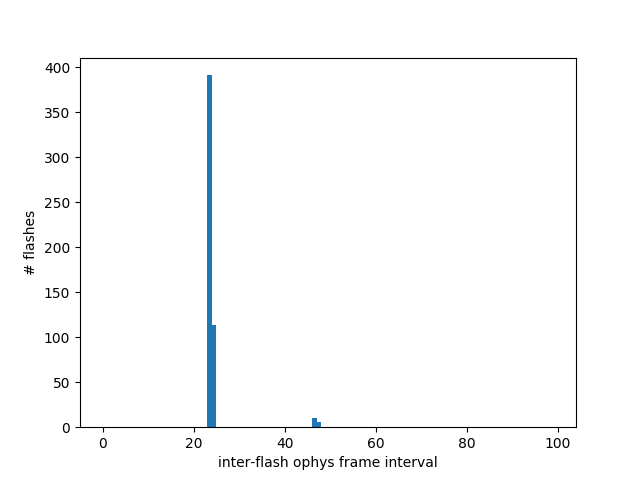

Text(0, 0.5, '# flashes')

In [119]:
plt.hist(np.diff(np.flatnonzero(this_image)), bins = np.arange(100))
plt.xlabel('inter-flash ophys frame interval')
plt.ylabel('# flashes')

<IPython.core.display.Javascript object>


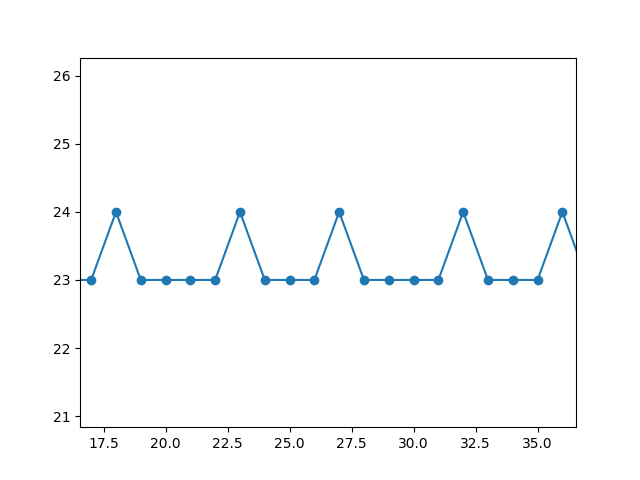

In [114]:
plt.plot(np.diff(np.flatnonzero(this_image)), '-o')
plt.y

In [121]:
from visual_behavior.ophys.response_analysis import response_processing
times_this_image = all_times_this_image[0]
nearest_ophys_frame = rp.index_of_nearest_value(session.ophys_timestamps, times_this_image)

<IPython.core.display.Javascript object>


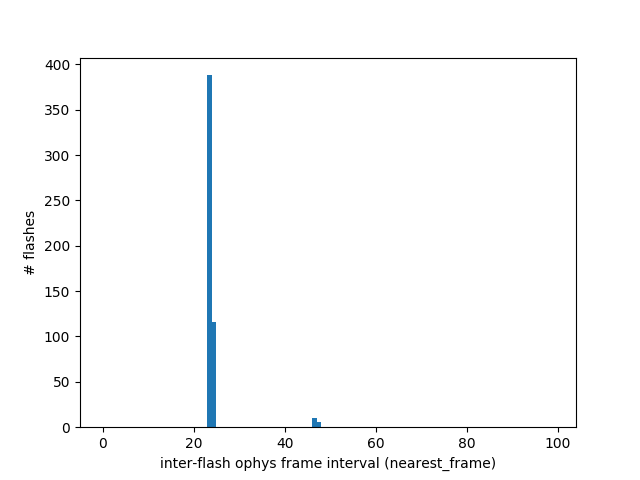

Text(0, 0.5, '# flashes')

In [123]:
plt.hist(np.diff(nearest_ophys_frame), bins = np.arange(100))
plt.xlabel('inter-flash ophys frame interval (nearest_frame)')
plt.ylabel('# flashes')

<IPython.core.display.Javascript object>


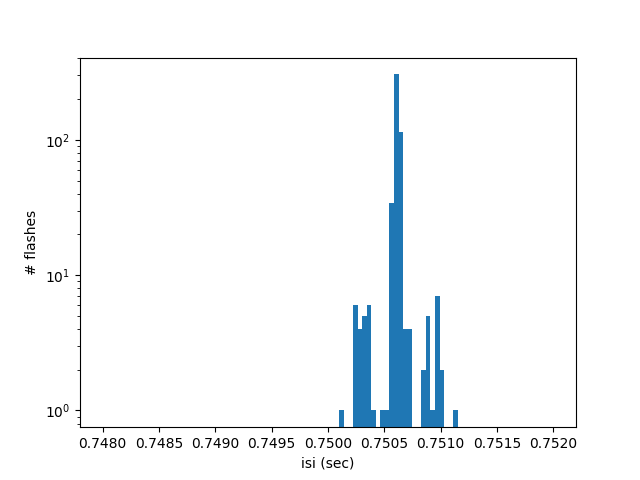

Text(0, 0.5, '# flashes')

In [132]:
plt.hist(np.diff(times_this_image), np.linspace(0.748, 0.752, 100))
plt.yscale('log')
plt.xlabel('isi (sec)')
plt.ylabel('# flashes')

<IPython.core.display.Javascript object>


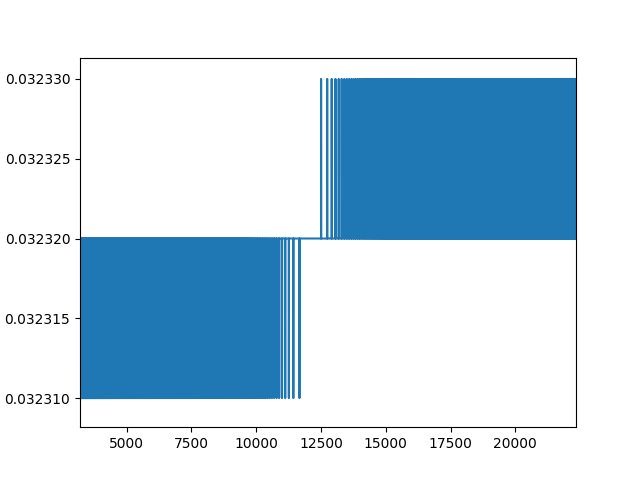

In [137]:
plt.plot(np.diff(session.ophys_timestamps))

In [15]:
X = design.X.T

In [16]:
X.shape # N samples x D features (kernel parameters)

(111607, 370)

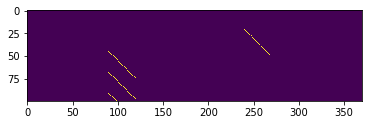

In [19]:
plt.imshow(X[:100, :])

In [22]:
dff_trace_arr.shape

(111607, 42)

In [41]:
W_prime = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.matmul(X.T, dff_trace_arr.values))

In [154]:
lam=70
W = np.dot(np.linalg.inv(np.dot(X.T, X) + lam*np.eye(X.shape[-1])), np.dot(X.T, dff_trace_arr))

In [155]:
W.shape

(370, 42)

In [43]:
np.testing.assert_allclose(W, W_prime) ## All good

$W_{OLS} = (X^TX)^{-1}X^TY$

$\hat{Y} = XW_{OLS}$

$U_r$ = first $r$ principal axes of $\hat{Y}$

$W_{RRR} = W_{OLS}U_rU_{r}^{T}$

In [185]:
Y_hat = np.dot(X, W)

In [157]:
W_this_cell = W[:, 0]

In [161]:
def get_kernel_dict(W_one_cell):
    return {l:W_one_cell[k[0]:k[1]] for l, k in list(zip(design.labels, (zip(design.ind_start, design.ind_stop))))}

In [159]:
kernels_dict.keys()

dict_keys(['im061', 'im062', 'im063', 'im065', 'im066', 'im069', 'im077', 'im085', 'omitted', 'change'])

<IPython.core.display.Javascript object>


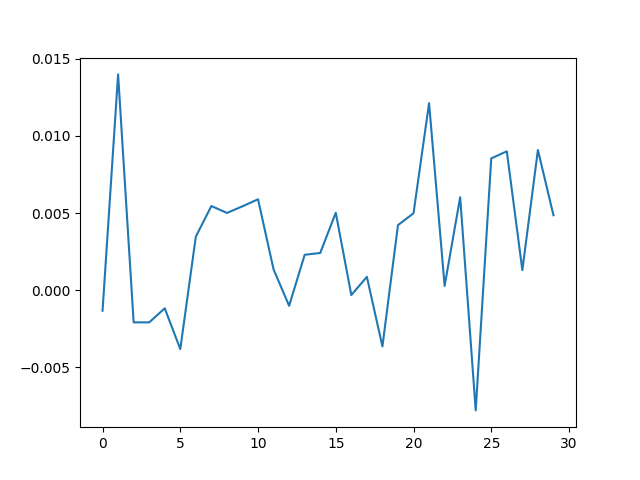

In [167]:
plt.plot(kernels_dict['im061'])

<IPython.core.display.Javascript object>


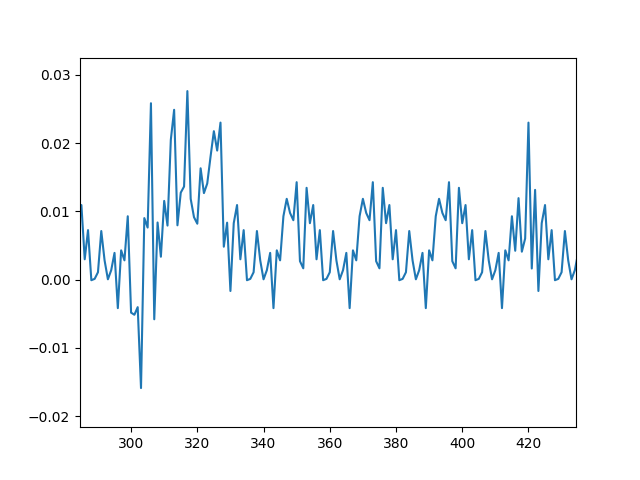

In [139]:
%matplotlib notebook
plt.plot(Y_hat[:1000,0])

In [50]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(Y_hat)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


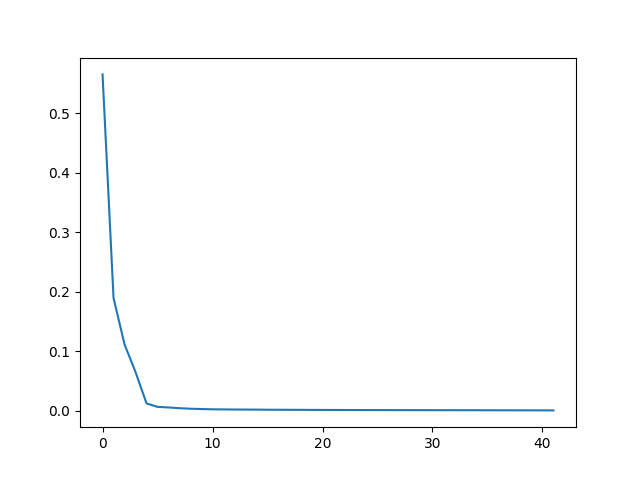

In [163]:
plt.plot(pca.explained_variance_ratio_)

In [57]:
pca.components_.shape

(42, 42)

In [197]:
U = pca.components_[:6, :]

In [198]:
U.shape

(6, 42)

In [199]:
W_RRR = np.dot(W, np.dot(U.T, U))

In [200]:
W_RRR.shape

(370, 42)

In [201]:
kernels = get_kernel_dict(W_RRR[:,0])

<IPython.core.display.Javascript object>


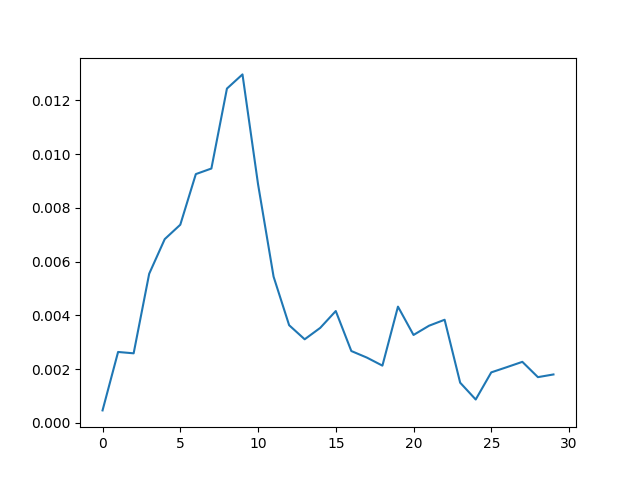

In [203]:
plt.plot(kernels['im061'])

In [204]:
traces_RRR = np.dot(X, W_RRR)

<IPython.core.display.Javascript object>


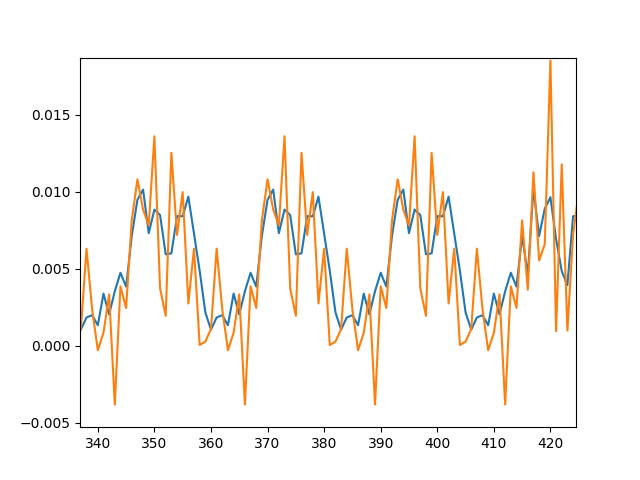

In [205]:
plt.plot(traces_RRR[:1000, 0])
plt.plot(Y_hat[:1000, 0])

In [75]:
CXY = np.dot(X.T, dff_trace_arr)

In [76]:
CXY.shape

(370, 42)

In [78]:
a = np.dot(CXY.T, W)

In [81]:
U, S, V = np.linalg.svd(a)

In [82]:
U.shape

(42, 42)

In [83]:
S.shape

(42,)

In [84]:
V.shape

(42, 42)

## General method to bin everything in the session onto a common timebase

In [85]:
session

In [86]:
session.stimulus_presentations.head()

,duration,end_frame,image_index,image_name,image_set,index,omitted,orientation,start_frame,start_time,stop_time,licks,rewards,change,time_from_last_lick,time_from_last_reward,time_from_last_change,mean_running_speed
stimulus_presentations_id,,,,,,,,,,,,,,,,,,
0,0.25021,18002.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,0,False,NaN,17987,305.37629,305.62650,"[305.65816, 306.11942]",[],False,18.36142,NaN,NaN,10.868218
1,NaN,NaN,8,omitted,omitted,0,True,NaN,18031,306.11022,NaN,[306.11942],[],False,0.45206,NaN,NaN,13.888171
2,0.25019,18092.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,1,False,NaN,18077,306.87751,307.12770,[307.23857],[],False,0.75809,NaN,NaN,16.701894
3,0.25020,18137.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,2,False,NaN,18122,307.62813,307.87833,[],[],False,0.38956,NaN,NaN,23.793409
4,0.25020,18182.0,0,im065,Natural_Images_Lum_Matched_set_training_2017.0...,3,False,NaN,18167,308.37874,308.62894,[],[],False,1.14017,NaN,NaN,19.758705


In [87]:
session.dff_traces.head()

,cell_roi_id,dff
cell_specimen_id,,
962553881,879015367,"[0.23483294666202828, 0.3557116043768097, 0.08..."
962552328,879015379,"[0.24761122405042116, 0.20317206458621523, 0.2..."
962552631,879015385,"[0.20565542377135362, 0.32884209971407263, 0.1..."
962553247,879015390,"[0.148354917083393, 0.12149700883006581, 0.178..."
962553919,879015404,"[0.31189798183333606, 0.29354865017785103, 0.2..."


In [88]:
session.ophys_timestamps

array([2.77803000e+00, 2.81034000e+00, 2.84265000e+00, ...,
       4.53130303e+03, 4.53133536e+03, 4.53136768e+03])

In [89]:
np.mean(np.diff(session.ophys_timestamps))

0.03232236540643937

In [90]:
np.min(session.ophys_timestamps)

2.77803

In [91]:
np.max(session.ophys_timestamps)

4531.36768